In [ ]:
import os

# Installing Dependencies

In [ ]:
if not os.path.exists("tumor_dataset"):
  !wget -q https://www.dropbox.com/s/4f314zcoo0lvlzn/Brain%20Tumor%20Segmentation.zip?dl=0 --output-document tumor_dataset.zip
  !unzip -q tumor_dataset.zip
  !rm tumor_dataset.zip
  !pip install -q torch_snippets pytorch_model_summary
  !pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.9 MB/s eta 0:00

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 23.0 MB/s eta 0:00:00


# Loading Libraires

In [ ]:
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
from torchvision.models import vgg16_bn

In [ ]:
from torchsummary import summary

In [ ]:
import numpy as np
from skimage import color


In [ ]:
from torchmetrics.functional import dice

In [ ]:
data_dir = "data"
image_dir_name = "images"
mask_dir_name = "masks"
image_dir = os.path.join(data_dir,image_dir_name)
mask_dir = os.path.join(data_dir,mask_dir_name)

In [ ]:
images = Glob(os.path.join(image_dir,"*.png"))
masks = Glob(os.path.join(mask_dir, "*.png"))

In [ ]:
print(len(images), len(masks))

3064 3064

# Visualizations

In [ ]:
img = read(images[0],1)

In [ ]:
img.shape

(512, 512, 3)

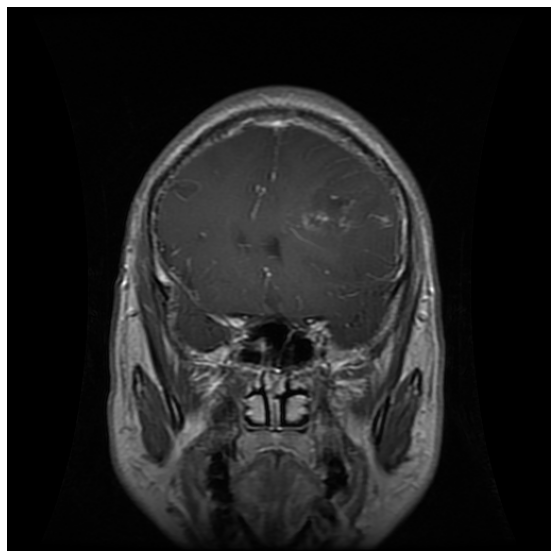

In [ ]:
show(img)

In [ ]:
msk = read(masks[0])


(512, 512)

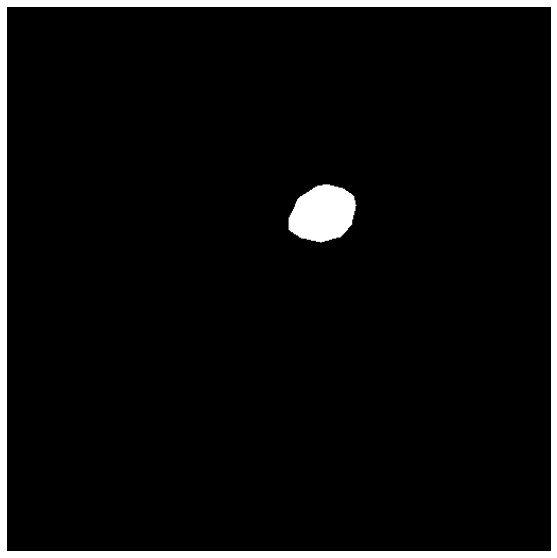

In [ ]:
print(msk.shape)
show(msk)

In [ ]:
msk = np.stack((msk,msk,msk),axis = 2)

In [ ]:
msk.shape

(512, 512, 3)

In [ ]:
overlayed_img = np.where(msk, (255,0,0), img) # Red overlay (255,0,0)

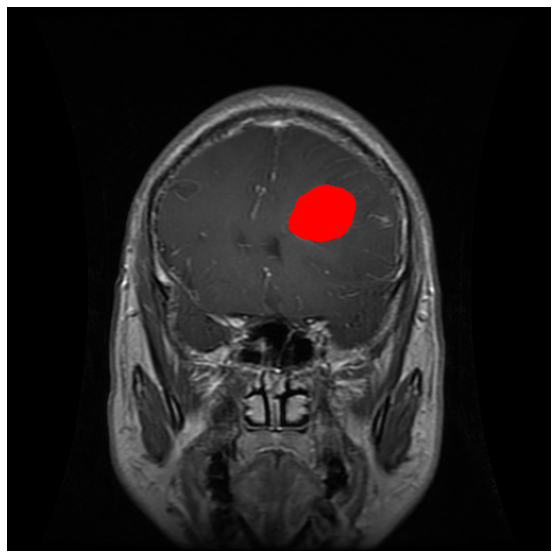

In [ ]:
show(overlayed_img)

#### Images have 3 channels whereas Masks have a single channel

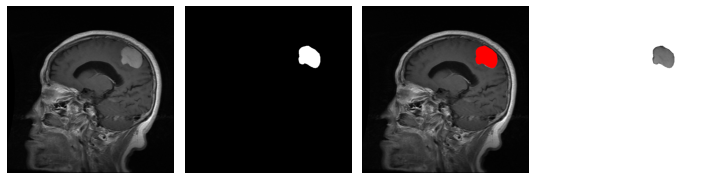

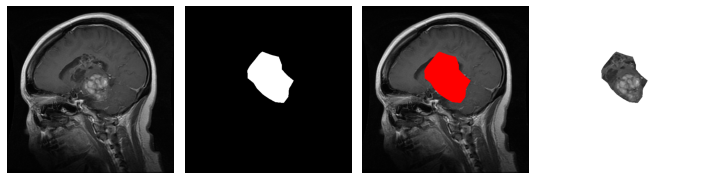

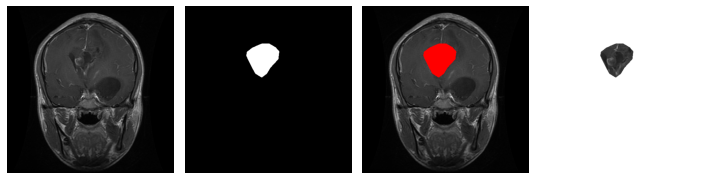

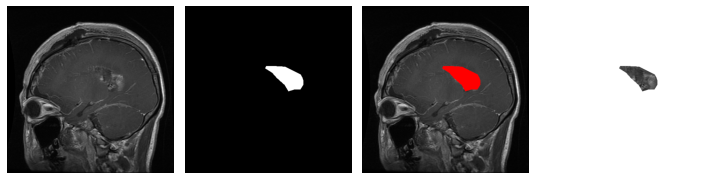

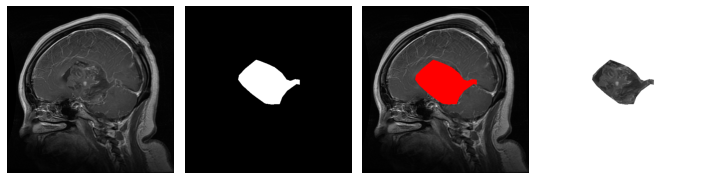

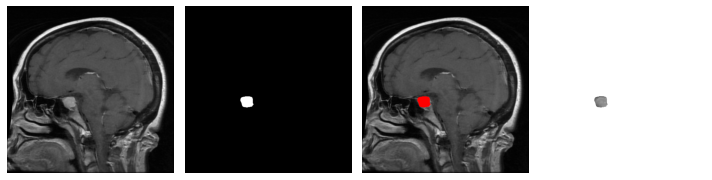

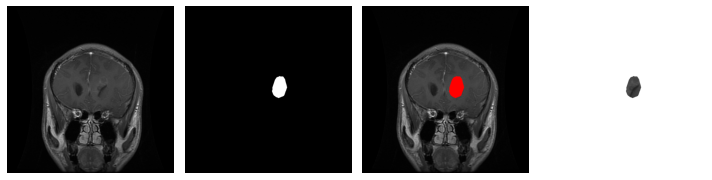

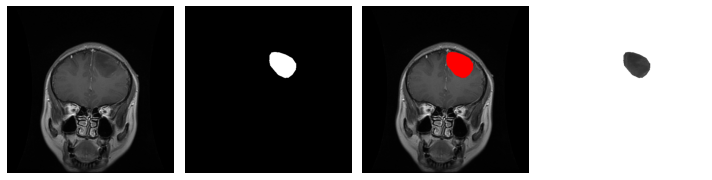

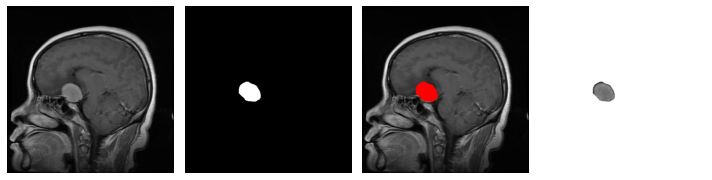

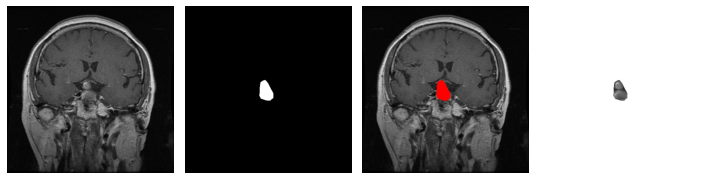

In [ ]:

for i in range(10):
  index = np.random.choice(len(images))
  img = read(images[index],1)
  msk = read(masks[index])
  msk_stack = np.stack((msk,msk,msk),axis = 2)
  overlayed_img = np.where(msk_stack, (255,0,0), img) # Red overlay (255,0,0)

  rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
  rgba[:, :, 3] = msk
  subplots([img,msk, overlayed_img, rgba], figsize = (10,10))


# Creating Training and Validation Split

In [ ]:
combined = list(zip(images,masks))

In [ ]:
trn_files, val_files = train_test_split(combined, random_state = 42,test_size=0.2)

# Building Dataset class

In [ ]:
# Image Transformation object
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
mask_tfms = transforms.ToTensor()

In [ ]:
class BrainTumorDataset(Dataset):
  def __init__(self, items):
    self.items = items

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
    item = self.items[ix]
    
    ## Getting image and mask path
    image_path = item[0]
    mask_path = item[1]
    
    ### Ingesting image and mask 
    image = read(image_path,1)
    mask = read(mask_path)

    ### resizing image and mask to 224,224. Will start with vgg16 backbone
    image = cv2.resize(image, (224,224))
    mask = cv2.resize(mask, (224,224))
    
    ## Adding depth dimension as image is greyscale
    mask = mask[...,np.newaxis]
    
    return image, mask

  def collate_fn(self,batch):
    ims, masks = list(zip(*batch))
    #print(ims)
    ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)

    ###########  Changing mask to float
    #ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).float().to(device)
    ce_masks = torch.cat([mask_tfms(mask.copy()/255.)[None] for mask in masks]).float().to(device)
    
    return ims, ce_masks

  def choose(self):
    return self[randint(len(self))]







# DataSet and DataLoaders

In [ ]:
train_ds = BrainTumorDataset(items=trn_files)
val_ds = BrainTumorDataset(items = val_files)

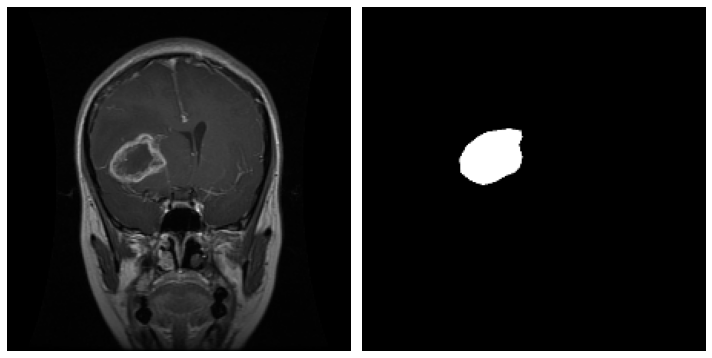

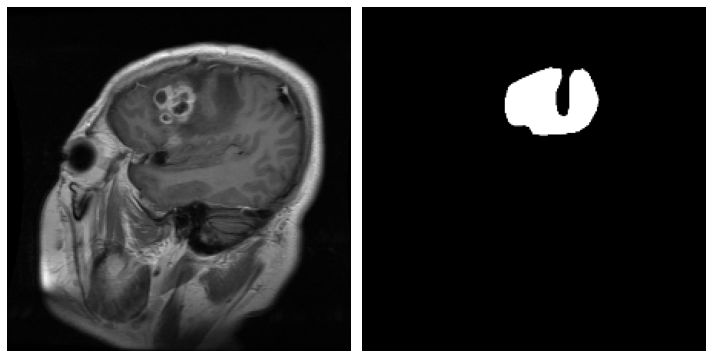

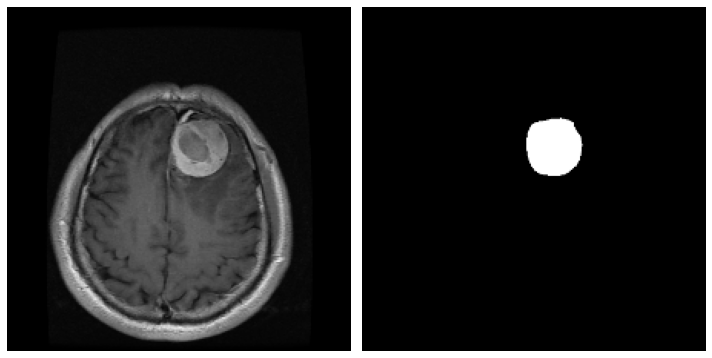

In [ ]:
### Plotting and seeing if everything in order till now
for i in range(3):
  random_img = train_ds.choose()
  
  subplots([random_img[0], random_img[1]], figsize = (10,10))

In [ ]:
### Data Loaders
train_dl = DataLoader(train_ds, batch_size = 4, shuffle  = True, collate_fn = train_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size = 1, collate_fn = val_ds.collate_fn)

In [ ]:
next(iter(train_dl))

(tensor[4, 3, 224, 224] n=602112 x∈[-2.118, 2.535] μ=-1.350 σ=0.701 cuda:0,
 tensor[4, 1, 224, 224] n=200704 x∈[0., 1.000] μ=0.019 σ=0.136 cuda:0)

# Model Building

In [ ]:
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3 , stride = 1, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True)
  )

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [ ]:
class UNet(nn.Module):
  def __init__(self, pretrained = True, out_channels = 1): 
    ## Check out channels meaning
    super().__init__()


    self.encoder = vgg16_bn(pretrained = pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512 + 512, 512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)
    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self,x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)

    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)

    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)

    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)

    x = self.conv11(x)

    return x





In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc
     


In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    #print(_masks)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [53]:
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    

    acc = (torch.max(input, 1)[1] == target).float().mean()
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth)), acc

In [77]:

model = UNet().to(device)
#criterion = UnetLoss
criterion = dice_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 20

In [78]:
for bx, data in enumerate(train_dl):
  #print(data[0])
  images , masks = data
  
  _mask = model(images)
  print(images)
  
  print(masks)
  print(_mask)

  
  #UnetLoss(_mask,masks)
  
  #print(UnetLoss(_mask,masks))
  print(dice_loss(_mask, masks))

  break

tensor[4, 3, 224, 224] n=602112 x∈[-2.118, 2.570] μ=-1.310 σ=0.732 cuda:0

tensor[4, 1, 224, 224] n=200704 x∈[0., 1.000] μ=0.012 σ=0.108 cuda:0

tensor[4, 1, 224, 224] n=200704 x∈[-2.016, 4.349] μ=-0.114 σ=0.404 grad ConvolutionBackward0 cuda:0

(tensor grad RsubBackward1 cuda:0 0.980, tensor cuda:0 0.988)

In [79]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000  trn_acc: 0.982  trn_loss: 1.115  val_acc: 0.983  val_loss: -4.116  (115.94s - 2202.82s remaining)
EPOCH: 2.000  trn_acc: 0.982  trn_loss: 0.973  val_acc: 0.983  val_loss: 0.421  (231.74s - 2085.64s remaining)
EPOCH: 3.000  trn_acc: 0.982  trn_loss: 1.026  val_acc: 0.983  val_loss: 1.013  (347.77s - 1970.67s remaining)
EPOCH: 4.000  trn_acc: 0.982  trn_loss: 0.990  val_acc: 0.983  val_loss: 0.969  (463.15s - 1852.60s remaining)
EPOCH: 5.000  trn_acc: 0.982  trn_loss: 1.007  val_acc: 0.983  val_loss: 1.023  (579.08s - 1737.25s remaining)
EPOCH: 6.000  trn_acc: 0.982  trn_loss: 1.146  val_acc: 0.983  val_loss: 0.526  (694.63s - 1620.81s remaining)
EPOCH: 7.000  trn_acc: 0.982  trn_loss: 1.100  val_acc: 0.983  val_loss: 1.025  (809.80s - 1503.91s remaining)
EPOCH: 8.000  trn_acc: 0.982  trn_loss: 1.068  val_acc: 0.983  val_loss: 1.038  (925.39s - 1388.08s remaining)
EPOCH: 9.000  trn_acc: 0.982  trn_loss: 1.031  val_acc: 0.983  val_loss: 0.984  (1040.67s - 1271.93s remaining)

100%|██████████| 121/121 [00:00<00:00, 258.94it/s]


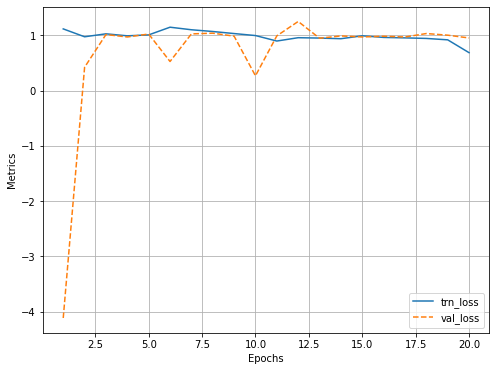

In [91]:

log.plot_epochs(['trn_loss','val_loss'])

In [101]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)


In [102]:
img, mask = val_ds.choose()

In [103]:
_mask = model(im)

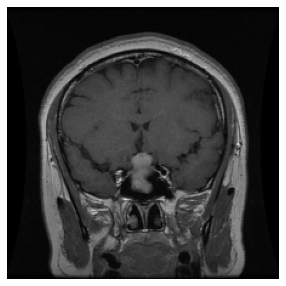

In [104]:
show(img)

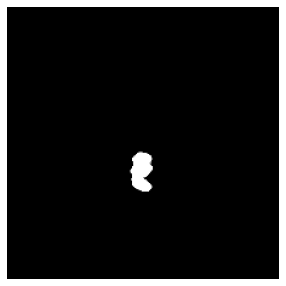

In [105]:
show(mask)

In [106]:
img = cv2.resize(img, (224,224))

In [107]:
img = tfms(img/255.).float().to(device)

In [108]:
_, _mask = torch.max(_mask, dim=1)

In [109]:
_mask

tensor[1, 224, 224] i64 all_zeros cuda:0

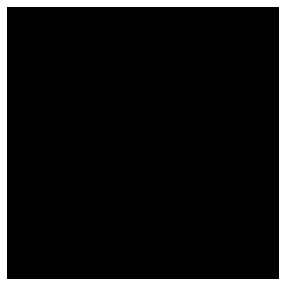

In [90]:
show(_mask.permute(1,2,0).squeeze())